<a href="https://colab.research.google.com/github/tirals88/pytorch-drl/blob/main/DRL_Chap2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

'PyTorch를 활용한 강화학습/심층강화학습 실전입문' 책 스터디 내용을 Google Colab으로 정리하여 올립니다.

Github 예제 코드 주소 : 'https://github.com/wikibook/pytorch-drl'

PyTorch를 활용한 강화학습/심층강화학습 실전입문

https://wikibook.co.kr/pytorch-drl/

## 2.2 미로와 에이전트 구현

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# 주피터 노트북 화면에 그림이나 도표를 출력하게 하는 설정

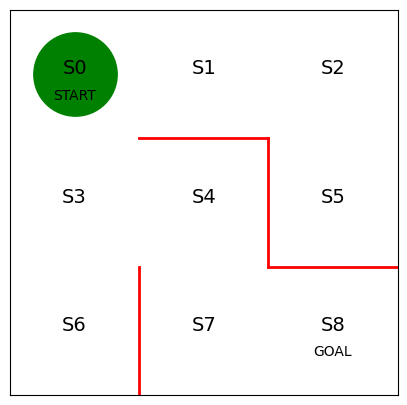

In [3]:
# 초기 상태의 미로 모습

# 전체 그림의 크기 및 그림을 나타내는 변수 선언
fig = plt.figure(figsize=(5,5))
ax = plt.gca()

# 붉은 벽 그리기 / 붉은 벽은 통과가 불가능함
plt.plot([1,1], [0,1], color='red', linewidth=2)
plt.plot([1,2], [2,2], color='red', linewidth=2)
plt.plot([2,3], [1,1], color='red', linewidth=2)
plt.plot([2,2], [1,2], color='red', linewidth=2)

# 상태를 의미하는 문자열(S0 ~ S8) 표시
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')

plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 그림을 그릴 범위 및 눈금 제거 설정
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

# S0에 녹색원으로 현재 위치를 표시
line, = ax.plot([0.5], [2.5], marker='o', color='g', markersize=60)

강화학습에서 에이전트가 어떻게 행동할지를 결정하는 규칙을 정책(policy)이라고 한다.

또한 상태가 $s$일 때, 행동 $a$를 취할 확률은 파라미터 𝛳가 결정하는 정책 π를 따른다는 의미로 $\pi_{\theta}(s, a)$로 표기한다.

미로탐색에서 상태 $s$는 에이전트의 미로 내 위치에 해당하며, 9개의 상태가 존재한다.

행동 $a$는 상태에 있을 떄 에이전트가 취할 수 있는 행동을 나타내며, 상, 하, 좌, 우로 이동하는 4가지 행동을 취할 수 있다. 다만 붉은 벽이 있는 방향으로의 이동은 할 수 없다.

정책 $\pi$ 는 다양한 방법으로 나타낼 수 있다. 함수로 나타낼 수도 있고, 심층강화학습에서는 신경망을 사용하기도 한다.

이번장의 태스크인 미로탐색에서는 정책을 타나내는 가장 간단한 방법인 표형식 표현(tabular representation)을 사용할 것이다. 표형식 표현은 행이 상태 $s$, 열이 행동 $a$를 나타낸다.

정책 $π$가 함수인 경우 파라미터 $\theta$는 함수의 변수가 되며, 정책이 신경망인 경우, 유닛 간의 결합 가중치에 해당한다. 표형식 표현으로 정책을 나타내게 되므로 상태 $s$에서 행동$a$를 취할 확률로 변환할 수 있는 값이 된다.

먼저 파라미터 $\theta$의 초깃값 $\theta_0$을 구현한다. 이동 가능한 방향에는 1, 벽이 있어 이동할 수 없는 방향에는 **np.nan**을 대입했다.

열의 순서는 상, 우 하, 좌로 상부터 시계방향순이다.

In [4]:
# 정책을 결정하는 파라미터의 초기값 theta_0 설정

# 행은 상태 0~7, 열은 방향(상, 우, 하, 좌)을 나타낸다
theta_0 = np.array([[np.nan, 1, 1, np.nan], # s0
                    [np.nan, 1, np.nan, 1], # s1
                    [np.nan, np.nan, 1, 1], # s2
                    [1, 1, 1, np.nan],      # s3
                    [np.nan, np.nan, 1, 1], # s4
                    [1, np.nan, np.nan, np.nan], # s5
                    [1, np.nan, np.nan, np.nan], # s6
                    [1, 1, np.nan, np.nan],     # s7
                            ])                            # s8은 목표지점이므로 정책이 없다

```np.nan : Return the sum of array elements over a given axis treating Not a Numbers (NaNs) as zero.```

In [ ]:
theta_0

array([[nan,  1.,  1., nan],
       [nan,  1., nan,  1.],
       [nan, nan,  1.,  1.],
       [ 1.,  1.,  1., nan],
       [nan, nan,  1.,  1.],
       [ 1., nan, nan, nan],
       [ 1., nan, nan, nan],
       [ 1.,  1., nan, nan]])

파라미터를 변환하여 정책을 구하는 방법은 아래와 같다. 단순한 변환 방법을 택해서 이동 방향에 대한 $\theta$ 값의 비율을 계산해서 확률로 삼는다.

In [5]:
# 정책 파라미터 theta를 행동 정책 pi로 변환하는 함수
def simple_convert_into_pi_from_theta(theta):
  '''단순히 값의 비율을 계산'''

  [m, n] = theta.shape
  pi = np.zeros((m, n))
  for i in range(0, m):
    pi[i, :] = theta[i, :] / np.nansum(theta[i, :]) # 각 행 내에서 취할 수 있는 값 비율

  pi = np.nan_to_num(pi) # nan을 0으로 변환

  return pi

In [ ]:
pi_0 = simple_convert_into_pi_from_theta(theta_0)
pi_0

array([[0.        , 0.5       , 0.5       , 0.        ],
       [0.        , 0.5       , 0.        , 0.5       ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [0.33333333, 0.33333333, 0.33333333, 0.        ],
       [0.        , 0.        , 0.5       , 0.5       ],
       [1.        , 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.5       , 0.5       , 0.        , 0.        ]])

In [4]:
# 에이전트가 정책을 따라 행동하게끔 명령
# 1단계 이동 후 에이전트의 상태를 구하는 함수 정의

def get_next_s(pi, s):
  direction = ["up", "right", "down", "left"]

  next_direction = np.random.choice(direction, p=pi[s, :])
  # 현재 상태가 s 일 때, s행의 가능한 행동(방향) a를 랜덤하게 선택

  if next_direction == "up":
    s_next = s - 3 # 위로 이동하려명 상태 값이 3만큼 감소해야한다

  elif next_direction == "right":
    s_next = s + 1

  elif next_direction == "down":
    s_next = s + 3

  elif next_direction == "left":
    s_next = s - 1

  return s_next

np.random.choice
- Parameters
    a : 1-D array-like or int
        If an ndarray, a random sample is generated from its elements.
        If an int, the random sample is generated as if it were ``np.arange(a)``
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  Default is None, in which case a
        single value is returned.
    replace : boolean, optional
        Whether the sample is with or without replacement. Default is True,
        meaning that a value of ``a`` can be selected multiple times.
    p : 1-D array-like, optional
        The probabilities associated with each entry in a.
        If not given, the sample assumes a uniform distribution over all
        entries in ``a``.

In [5]:
# 목표 지점에 이를 때 까지 에이전트를 계속 이동시키는 함수

def goal_maze(pi):
  s = 0
  state_history = [0]

  while(1):
    next_s = get_next_s(pi, s)
    state_history.append(next_s)

    if next_s == 8:
      break

    else:
      s = next_s

  return state_history

In [ ]:
# 목표지점에 이를 때까지 미로 안을 이동
state_history = goal_maze(pi_0)
print(state_history)
print("목표 지점에 이르기까지 걸린 단계 수는 {} 단계 입니다.".format(len(state_history)-1))

[0, 1, 2, 1, 2, 1, 0, 3, 6, 3, 0, 1, 2, 1, 0, 1, 2, 5, 2, 1, 0, 3, 4, 7, 4, 3, 4, 3, 0, 1, 0, 3, 6, 3, 0, 1, 0, 1, 0, 1, 0, 3, 6, 3, 0, 1, 2, 5, 2, 5, 2, 1, 2, 1, 2, 1, 0, 3, 0, 1, 2, 1, 0, 1, 0, 3, 6, 3, 0, 1, 2, 1, 2, 5, 2, 1, 2, 1, 2, 1, 0, 1, 0, 1, 2, 1, 2, 5, 2, 1, 2, 5, 2, 1, 2, 1, 0, 1, 2, 5, 2, 5, 2, 1, 0, 1, 2, 5, 2, 1, 0, 1, 2, 5, 2, 5, 2, 1, 0, 1, 2, 5, 2, 1, 0, 3, 6, 3, 6, 3, 4, 3, 4, 7, 8]
목표 지점에 이르기까지 걸린 단계 수는 134 단계 입니다.


In [ ]:
# 에이전트의 이동 과정을 시각화
from matplotlib import animation
from IPython.display import HTML

def init():
  '''배경 이미지 초기화'''
  line.set_data([], [])
  return (line, )

def animate(i):
  '''프레임 단위로 이미지 생성'''
  state = state_history[i] # 현재 위치
  x = (state % 3) + 0.5
  y = 2.5 - int(state / 3)
  line.set_data([x], [y])
  # 교재 내 코드 : line.set_data(x, y)
  # MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  # set_data(x, y) --> set_data([x], [y])
  return (line, )

# 초기화 함수와 프레임 단위 이미지 생성 함수를 사용해 애니메이션 생성
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(state_history),
                               interval = 150, repeat=False) # 전체 그림 fig 에 정의한 함수 animate 사용 + line 이 global variable 임

HTML(anim.to_jshtml())

In [ ]:
#matplotlib.animation.FuncAnimation
#matplotlib.animation.FuncAnimation(fig, func, frames=None, init_func=None, fargs=None, save_count=None, *, cache_frame_data=True, **kwargs)[source]

The function to call at each frame. The first argument will be the next value in frames. Any additional positional arguments can be supplied using functools.partial or via the fargs parameter.

The required signature is:

```
def func(frame, *fargs) -> iterable_of_artists
```

It is often more convenient to provide the arguments using functools.partial. In this way it is also possible to pass keyword arguments. To pass a function with both positional and keyword arguments, set all arguments as keyword arguments, just leaving the frame argument unset:


```
def func(frame, art, *, y=None):
    ...

ani = FuncAnimation(fig, partial(func, art=ln, y='foo'))
```


If blit == True, func must return an iterable of all artists that were modified or created. This information is used by the blitting algorithm to determine which parts of the figure have to be updated. The return value is unused if blit == False and may be omitted in that case.

## 2.3 정책반복(Policy Gradient) 구현

앞절에서 미로 안을 무작위로 이동하는 정책을 구현했다. 사실 확률에 따라 무작위로 왔다갔다하다가 목표에 얻어걸리는 상황이랑 다르지 않았다.

이번에는 목표로 곧장 향하도록 정책을 학습시킬 것이다. 크게 두 가지 방법이 있다.

첫 번째는 정책에 따라 목표에 빠르게 도달했던 경우에 수행했던 행동(action)을 중요한 것으로 보고, 이때의 행동을 앞으로도 취할 수 있도록 정책을 수정하는 방법이다. 다시 말해 결과가 좋았던 경우에 중시하는 것이다. 딥러닝의 gradient descent와 같은 아이디어로 보인다.

두 번째는 목표 지점부터 거슬러 올라가며 목표 지점과 가까운 상태로 에이전트를 유도해 오는 방법이다. 즉 목표 지점 외의 지점에도 가치를 부여하는 것이다.

첫 번째 방법을 정책반복이라고 하며, 두 번째 방법은 가치반복이라고 한다. 이번 절에서는 정책반복 알고리즘 중 하나인 정책경사(policy gradient) 알고리즘을 구현해 보겠다.

이번에는 변환함수를 simple_convert_into_pi_from_theta 함수가 아닌, softmax 함수를 사용할 것이다.

소프트맥스 함수의 정의는 다음과 같다.

$$P(\theta_i) = \frac{exp(\beta\theta_i)}{\sum_{j=1}^{N_a}{exp(\beta\theta_j)}}$$

$\beta$ 는 역온도 inverse temperature라고 하며 역온도가 작아질수록 행동이 무작위로 선택된다.

아래 코드로 확인한 결과 $\beta$가 커질수록 파라미터 내의 지배적인 값에 치중된 확률이 출력된다.

이는 softmax 함수가 아닌 기존의 변환함수에서는 $\beta$가 곱해진다고 해도 약분이 이루어질수 있었지만, softmax 함수의 사용에서는 $\beta$가 지수에 곱해지기 때문에, 변수가 동일하게 $e^{\beta}$만큼 곱해지지 않고 $\beta$만큼 제곱하게 되어 변수간의 간격이 멀어지게 된다.

In [ ]:
beta_1 = 1
beta_2 = 2
beta_3 = 4

theta_1 = [1,2,3,4,5]
theta_2 = np.exp(theta_1)

theta_3 = np.exp(np.dot(theta_1,beta_2))

theta_4 = np.exp(np.dot(theta_1,beta_3))

print(theta_2)
print(theta_3)
print('\n', theta_2[0]/np.sum(theta_2), '\t', theta_3[0]/np.sum(theta_3), '\t', theta_4[0]/np.sum(theta_4))
print('\n', theta_2[1]/np.sum(theta_2), '\t', theta_3[1]/np.sum(theta_3), '\t', theta_4[1]/np.sum(theta_4))
print('\n', theta_2[2]/np.sum(theta_2), '\t', theta_3[2]/np.sum(theta_3), '\t', theta_4[2]/np.sum(theta_4))
print('\n', theta_2[3]/np.sum(theta_2), '\t', theta_3[3]/np.sum(theta_3), '\t', theta_4[3]/np.sum(theta_4))
print('\n', theta_2[4]/np.sum(theta_2), '\t', theta_3[4]/np.sum(theta_3), '\t', theta_4[4]/np.sum(theta_4))

[  2.71828183   7.3890561   20.08553692  54.59815003 148.4131591 ]
[7.38905610e+00 5.45981500e+01 4.03428793e+02 2.98095799e+03
 2.20264658e+04]

 0.011656230956039607 	 0.0002900758675640402 	 1.1047402132452448e-07

 0.03168492079612427 	 0.0021433868583766707 	 6.031677191041164e-06

 0.0861285444362687 	 0.015837605738255944 	 0.0003293184162279595

 0.23412165725273662 	 0.11702495727271915 	 0.017980176297891573

 0.6364086465588308 	 0.8647039742630842 	 0.9816843631346681


In [ ]:
# softmax_convert_into_pi_from_theta 함수 구현
def softmax_convert_into_pi_from_theta(theta):
  '''비율 계산에 소프트맥스 함수 사용'''

  beta= 1.0
  [m, n] = theta.shape
  pi = np.zeros((m, n))

  exp_theta = np.exp(beta * theta)

  for i in range(0, m):
    # pi[i, :] = theta[i, :] / np.nansum(theta[i, :])
    # 비교 코드
    pi[i, :] = exp_theta[i, :] / np.nansum(exp_theta[i, :])

  pi = np.nan_to_num(pi)

  return pi

In [ ]:
# 초기 정책 pi_0 계산
pi_0 = softmax_convert_into_pi_from_theta(theta_0)
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.5        0.5       ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.5        0.5       ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]]


초기 상태에서는 두 방법의 결과가 같지만, 학습에 따라 $\theta$값이 달라지면서 두 방법의 정책값이 서로 크게 달라지게 된다.

In [ ]:
# get_next_s 함수에서 수정된 함수
# 각 상태에서 취한 행동들 또한 반환하도록 수정

def get_action_and_next_s(pi, s):
  direction = ["up", "right", "down", "left"]

  next_direction = np.random.choice(direction, p=pi[s, :])
  # 현재 상태가 s 일 때, s행의 가능한 행동(방향) a를 랜덤하게 선택

  if next_direction == "up":
    action = 0
    s_next = s - 3 # 위로 이동하려명 상태 값이 3만큼 감소해야한다

  elif next_direction == "right":
    action = 1
    s_next = s + 1

  elif next_direction == "down":
    action = 2
    s_next = s + 3

  elif next_direction == "left":
    action = 3
    s_next = s - 1

  return [action, s_next]

In [ ]:
# goal_maze 함수에서 수정된 함수
# get_action_and_next_s 함수에서 새로 반환한 행동까지 함께 반환하도록 수정

def goal_maze_ret_s_a(pi):
  s = 0
  s_a_history = [[0, np.nan]]

  while(1):
    # j 시점에서 [action, s_next] : 취할 행동의 종류(방향), j+1 시점의 상태(위치)
    [action, next_s] = get_action_and_next_s(pi, s)

    # j 시점에서 취하는 행동의 종류 입력
    s_a_history[-1][1] = action

    # j+1 시점의 상태 미리 입력, j+1 시점에서 취할 행동은 아직 알 수 없으므로 nan으로 입력
    s_a_history.append([next_s, np.nan])

    if next_s == 8:
      break

    else:
      s = next_s

  return s_a_history

In [ ]:
# 초기 정책으로 미로 빠져나오기
s_a_history = goal_maze_ret_s_a(pi_0)
print(s_a_history)
print("목표 지점에 이르기까지 걸린 단계 수는 {} 단계 입니다.".format(len(s_a_history)-1))

[[0, 1], [1, 1], [2, 3], [1, 3], [0, 1], [1, 1], [2, 3], [1, 3], [0, 1], [1, 3], [0, 2], [3, 1], [4, 2], [7, 0], [4, 3], [3, 0], [0, 1], [1, 1], [2, 3], [1, 1], [2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 3], [1, 3], [0, 1], [1, 3], [0, 1], [1, 3], [0, 2], [3, 1], [4, 3], [3, 0], [0, 1], [1, 3], [0, 2], [3, 0], [0, 1], [1, 1], [2, 3], [1, 1], [2, 3], [1, 3], [0, 1], [1, 1], [2, 2], [5, 0], [2, 2], [5, 0], [2, 3], [1, 3], [0, 2], [3, 2], [6, 0], [3, 0], [0, 2], [3, 0], [0, 2], [3, 0], [0, 1], [1, 1], [2, 2], [5, 0], [2, 3], [1, 3], [0, 1], [1, 3], [0, 2], [3, 2], [6, 0], [3, 0], [0, 1], [1, 1], [2, 3], [1, 1], [2, 3], [1, 1], [2, 2], [5, 0], [2, 3], [1, 1], [2, 2], [5, 0], [2, 2], [5, 0], [2, 2], [5, 0], [2, 3], [1, 1], [2, 3], [1, 1], [2, 3], [1, 1], [2, 3], [1, 1], [2, 3], [1, 1], [2, 3], [1, 3], [0, 1], [1, 3], [0, 1], [1, 1], [2, 3], [1, 1], [2, 2], [5, 0], [2, 2], [5, 0], [2, 3], [1, 1], [2, 2], [5, 0], [2, 3], [1, 1], [2, 2], [5, 0], [2, 3], [1, 3], [0, 2], [3, 2], [6, 0],

이제 목표 지점에 도달하였다. 그렇지만 이게 끝이 아니다. 이 과정은 시작에 불과하고 지금부터 앞선 과정에 대한 피드백과 반복이 필요하다.

다음으로 정책경사 알고리즘으로 정책을 수정하는 부분을 구현할 차례이다. 정책경사 알고리즘은 아래와 같이 파라미터 $\theta$ 를 수정한다.

$$\theta_{s_{i}, a_{j}} = \theta_{s_{i}, a_{j}} + \eta \; \centerdot \; 𝛥 \theta_{s, a_{j}} $$

$$𝛥 \theta_{s, a_{j}} = \{ N(s_{i}, a_{j}) + P(s_{i}, a_{j})N(s_{i}, a)\}/T$$

$N(s_{i}, a_{j})$ : 상태 $s_{i}$에서 $a_{j}$를 취했던 횟수

$P(s_{i}, a_{j})$ : 현재 정책하에서 상태 $s_{i}$일 때, 행동 $a_{j}$를 취할 확률을 각각 나타낸다. 이전에 softmax 함수를 써서 구했던 확률값이다.

$N(s_{i}, a)$ : 상태 $s_{i}$에서 행동을 취한 횟수의 합계

$T$ : 목표 지점에 이르기까지 걸린 모든 단계의 수


In [ ]:
#theta 수정식

def update_theta(theta, pi, s_a_history):
  eta = 0.1 #learning_rate
  T = len(s_a_history) - 1 #목표지점 제외

  [m, n] = theta.shape
  delta_theta = theta.copy() #포인터 참조이므로 copy()

  #delta_theta 요소 단위로 계산
  for i in range(m):
    for j in range(n):
      if not(np.isnan(theta[i, j])): #nan 이 아닌 경우
        SA_i = [SA for SA in s_a_history if SA[0] == i]
        # 히스토리에서 상태 i 인 것만 모아놓은 리스트

        SA_ij = [SA for SA in s_a_history if SA==[i, j]]
        # 히스토리에서 상태 i일 때 행동 j를 취한 경우를 모은 리스트

        N_i = len(SA_i)
        N_ij = len(SA_ij)

        delta_theta[i, j] = (N_i + pi[i, j]*N_ij) / T

  new_theta = theta + eta*delta_theta

  return new_theta

In [ ]:
#정책 수정
new_theta = update_theta(theta_0, pi_0, s_a_history)
pi = softmax_convert_into_pi_from_theta(new_theta)
print(pi_0)
print(pi)

[[0.         0.5        0.5        0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.         0.5        0.5       ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.5        0.5       ]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]]
[[0.         0.50057692 0.49942308 0.        ]
 [0.         0.50067308 0.         0.49932692]
 [0.         0.         0.49932692 0.50067308]
 [0.33353279 0.33327633 0.33319088 0.        ]
 [0.         0.         0.49990385 0.50009615]
 [1.         0.         0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.5        0.5        0.         0.        ]]


In [ ]:
#정책 경사 알고리즘으로 미로 빠져나오기

stop_epsilon = 10e-4 #정책의 변화가 이보다 작아지면 학습 종료

## 초기값
theta = theta_0
pi = pi_0

is_continue = True
count = 1
while is_continue:
  count += 1
  s_a_history = goal_maze_ret_s_a(pi) #정책을 따라 미로를 탐색한 히스토리를 구함
  new_theta = update_theta(theta, pi, s_a_history) #파라미터 theta수정
  new_pi = softmax_convert_into_pi_from_theta(new_theta) #정책 pi 수정

  #print(np.sum(np.abs(new_pi - pi))) #정책 변화 출력
  if count%20 == 0:
    print("count : {} ".format(count), "목표 지점에 이르기까지 걸린 단계 수는 {}단계 입니다.".format(len(s_a_history)-1), ' 변화 : {}'.format(np.sum(np.abs(new_pi - pi))))

  if np.sum(np.abs(new_pi - pi)) < stop_epsilon:
    is_continue = False

  else:
    theta = new_theta
    pi = new_pi

print('총 반복 횟수 : {}'.format(count))

count : 20  목표 지점에 이르기까지 걸린 단계 수는 44단계 입니다.  변화 : 0.0036651584943059867
count : 40  목표 지점에 이르기까지 걸린 단계 수는 4단계 입니다.  변화 : 0.023517068241793004
count : 60  목표 지점에 이르기까지 걸린 단계 수는 66단계 입니다.  변화 : 0.007142824338862708
count : 80  목표 지점에 이르기까지 걸린 단계 수는 18단계 입니다.  변화 : 0.013099276437964658
count : 100  목표 지점에 이르기까지 걸린 단계 수는 72단계 입니다.  변화 : 0.0034698622354124575
count : 120  목표 지점에 이르기까지 걸린 단계 수는 22단계 입니다.  변화 : 0.008086398042749021
count : 140  목표 지점에 이르기까지 걸린 단계 수는 24단계 입니다.  변화 : 0.008524416870563822
count : 160  목표 지점에 이르기까지 걸린 단계 수는 10단계 입니다.  변화 : 0.015026677819541923
count : 180  목표 지점에 이르기까지 걸린 단계 수는 14단계 입니다.  변화 : 0.007995064320206191
count : 200  목표 지점에 이르기까지 걸린 단계 수는 8단계 입니다.  변화 : 0.014124318178829531
count : 220  목표 지점에 이르기까지 걸린 단계 수는 8단계 입니다.  변화 : 0.014911283094633021
count : 240  목표 지점에 이르기까지 걸린 단계 수는 4단계 입니다.  변화 : 0.02643416696459333
count : 260  목표 지점에 이르기까지 걸린 단계 수는 8단계 입니다.  변화 : 0.014647990541452965
count : 280  목표 지점에 이르기까지 걸린 단계 수는 10단계 입니다.  변화 : 0.01246451000484132
c

# 2.4 가치반복 알고리즘 관련 용어 정리

이번 절에서는 보상, 행동가치, 상태가치, 벨만 방정식, 마르코프 결정 프로세스 등의 대해 알아본다.

## 보상

먼저 가치를 결정하려면 어떤 일정한 척도에 해당하는 개념이 필요하다.

강화학습에서는 가치의 척도로 보상(reward)이라는 개념을 사용한다. 미로 태스크를 예로 들면 목표 지점에 도달했을 때 보상을 부여하고, 로봇의 보행 태스크라면 넘어지지 않고 걸어간 거리를 보상으로 삼을 수 있다. 바둑이라면 대국 승리를 보상이라 볼 수 있다.

여기서 어떤 시각 $t$에 받을 수 있는 보상 $R_{t}$를 즉각보상(immediate reward)이라고 한다. 그리고 강화학습에서는 보상 $R_{t}$를 태스크에 맞게 적절히 결정해야 한다.

그리고 앞으로 받을 수 있으리라 예상되는 보상의 합계 $G_{t}$를 총 보상이라고 한다.

$$G_{t} = R_{t+1} + R_{t+2} + R_{t+3} + \cdots$$

다만 이 경우에는 시간의 경과를 고려해야하니 이자율을 포함시켜야 한다. 예를 들어 1만원을 은행에 10년 동안 예치시켜 놓는다면 복리로 이자가 붙어 10년 후에는 액수가 조금 늘어 있을 것이다.

 반대로 생각하면 10년 후의 1만원의 가치가 현재의 가치보다 조금 적다고 봐야 한다. 이렇듯 미래의 보상을 할인하는 것을 시간할인(time discount)이라고 하며, 이때의 할인율은 $\gamma$로 나타낸다.

 시간의 경과에 따라 보상합계에 이율 및 복리효과를 적용한 경우에는 할인총보상(dicounted total reward) $G_{t}$를 사용한다.

 $$G_{t} = R_{t+1} + \gamma R_{t+2} + \gamma^{2}R_{t+3} + \cdots$$



## 행동가치와 상태가치

보상을 정의했으니 가치 개념을 도입할 차례이다. 가치반복 알고리즘에는 행동가치(action value)와 상태가치(state value)라는 두 가지 가치를 정의한다.

먼저 **행동가치**를 정의한다. 미로 태스크에서 에이전트가 S7에 있다고 가정하자. 이 때 행동 $a = 1$을 하면 목표 지점에 이르러 보상 $R_{t+1}$을 받을 수 있다. 이 내용을 식으로 나타내면 다음과 같다.

$$Q^{\pi}(s=7, a=1) = R_{t+1} = 1$$

그럼 에이전트가 행동 $a=0$을 하게 된다면, 목표 지점으로부터 멀어지며 목표에 다다르기 위해서는 S7 → S4 →S7 →S8로  두 단계가 늘어난다, 이를 식으로 나타내면 다음과 같다.

$$Q^{\pi}(s=7, a=0) = R_{t+1} = \gamma^{2} *1$$

이어서 상태가치를 설명한다.

상태가치는 상태 $s$에서 정책 $\pi$를 따라 행동할 때 얻으리라 기대할 수 있는 할인총보상 $G_{t}$를 말한다.

예를 들어 에이전트가 S7에서 오른쪽으로 이동하면 목표지점에 도달해서 보상1을 받을 수 있는데, 이를 다음식과 같이 나타낼 수 있다.

$$V^{\pi}(s=7)= 1$$

또한 에이전트가 S4에 있을 때 아래로 이동하면 S7에 도착하게 되고 여기서 오른쪽으로 이동하면 목표지점에 도달하므로 상태가치 함수는 다음과 같다.

$$V^{\pi}(s=4) =  R_{t+1} + \gamma * V^{\pi}(s=7)$$

이 때, $R_{t+1}$은 상태 S7이 됐을 때 바로 받게 되는 즉각보상이지만, 여기서는 목표 지점 외에는 즉각보상이 없으므로 0이 된다.

## 벨만 방정식과 마르코프 결정 프로세스

앞서 설명했던 상태가치 함수의 수식을 좀 더 일반화하면 다음 식과 같이 나타낼 수 있다.

$$V^{\pi}(s) = max^{}_{a}{\:𝔼[R_{x, a} + \gamma * V^{\pi}(s(s,a))]}$$

이 식을 벨만 방정식 (Bellman equation)이라고 한다. 우변의 $R_{s, a}$는 상태 $s$에서 행동 $a$를 취했을 때 얻을 수 있는 즉각보상 $R_{t+1}$을 의미하며, $s(s, a)$는 상태 $s$에서 행동 $a$를 취해서 이동한 다음 단계의 새로운 상태 $s_{t+1}$을 의미한다.

이는 행동가치 함수에서도 성립힌다.

벨만 방정식이 성립하려면 학습 대상이 마르코프 결정 프로세스 (Markov decision process, MDP)이어야 한다는 전제조건을 만족해야한다.

마르코프 결정 프로세스, MDP는 다음 단계의 상태 $s_{t+1}$이 현재 상태 $s_{t}$에서 취한 행동 $a_{t}$에 의해 결정되는 시스템을 말한다.

반면 마르코프 결정 프로세스가 아닌 것은, 상태 $s_{t+1}$이 $s_{t}$ 외의 과거 예를 들어 $s_{t-1}$로부터도 영향을 받는 시스템이 해당한다.

# 2.5 Sarsa 알고리즘 구현



## $\epsilon$-gready 알고리즘으로 정책 구현하기

가치반복 알고리즘의 한 종류인 Sarsa를 구현해 보겠다. 초기상태를 실행한 후 가치반복 알고리즘에서 사용할 행동가치 함수를 표형식 표현을 구현할 것이다. 행은 상태 $s$를, 열은 행동 $a$를 나타내는 형태로 행동가치 함수 $Q(s, a)$를 구현한다. 실제 행동가치는 우리가 알 수 없으니 초기 상태로 난수값을 부여한다.

In [34]:
# 행동가치 함수 Q의 초기 상태

[a, b] = theta_0.shape
## 벽에 해당하는 부분을 난수에서 np.nan 으로 바꿔줌
Q = np.random.rand(a, b) * theta_0
# * theta_0 요소 단위 곱셈을 수행, Q에서 벽 방향으로 이동하는 행동에는 nan 을 부여

각 시각에서 행동가치 함수 $Q$에서 행동 $a$를 계산하기 위한 정책을 구현한다. 단순하게 생각하면 $Q$ 값이 최대가 되는 행동을 고르기만 하면 된다(이러한 전략을 탐욕적 전략이라고 한다).


그러나 제대로 계산되어 있지 않은 상태에서 이 전략을 채용하면, 무작위로 생성한 행동가치 함수 $Q$의 초깃값에 따라 행동이 결정되고 그 뒤로 학습이 제대로 일어나지 않을 가능성이 있다.

이 때문에 일정 확률 $\epsilon$으로 무작위 행동을 취하고, 나머지 확률 $1-\epsilon$으로 행동가치 $Q$가 최대가 되는 행동을 취하기로 한다. 이러한 알고리즘을 $\epsilon$-greedy라고 한다. 이때 $\epsilon$ 값은 시행 회차가 늘어남에 따라 작아지게 한다.

가치반복 알고리즘에서는 현재 행동가치 함수의 최댓값을 이용해 행동을 결정하는 방법(이용, exploit)과 무작위로 행동을 선택하는 방법(탐색, explore)을 적절히 섞어야 한다. 이를 탐색-이용 트레이드오프(explore-exploit tradeoff)라고 한다.

아래는 $\epsilon$-greedy 알고리즘을 구현한 코드이다.

In [35]:
#정책 파라미터 theta_0를 무작위 행동 정책 pi로 변환하는 함수

#simple_convert_into_pi_from_theta() 함수 정의

pi_0 = simple_convert_into_pi_from_theta(theta_0)

In [7]:
#e-greedy 알고리즘 구현

def get_action(s, Q, epsilon, pi):
  direction = [0, 1, 2, 3] #["up", "right", "down", "left"]

  if np.random.rand() < epsilon:
    # 확률 e로 무작위 행동 선택
    next_direction = np.random.choice(direction, p = pi[s, :])
  else:
    #Q값이 최대가 되는 행동을 선택/확률 1-e
    next_direction = direction[np.nanargmax(Q[s, :])]

  return next_direction

In [9]:
def get_s_next(s, a):
  ##direction = [0, 1, 2, 3] #["up", "right", "down", "left"]
  next_direction = a

  if next_direction == 0:
    s_next = s - 3

  elif next_direction == 1:
    s_next = s + 1

  elif next_direction == 2:
    s_next = s + 3

  elif next_direction == 3:
    s_next = s - 1

  return s_next

행동가치 함수 $Q(s, a)$가 제대로 된 값이 될 수 있도록 학습하는 부분을 구현하겠다. 여기서는 함수를 수정하는데 Sarsa라는 알고리즘을 사용한다. 행동가치 함수 $Q(s, a)$가 이미 제대로 돼있다면 벨만 방정식에 따라 다음 관계식이 성립한다.

$$Q(s_{t}, a_{t}) = R_{t+1} + \gamma \;Q(s_{t+1}, a_{t+1})$$

그러나 학습 중에는 행동가치 함수가 정확하지 않기 때문에 등호가 성립하기 힘들다. 위 식에서 양변의 차이를 TD 오차 (Temporal difference error)라고 한다.

$Q$는 다음 식에 따라 수정한다.

$$Q(s_{t}, a_{t}) = Q(s_{t}, a_{t}) + \eta * (R_{t+1} + \gamma \;Q(s_{t+1}, a_{t+1}) - Q(s_{t}, a_{t}))$$

현재 상태 $s$와 행동 $a$, 즉각보상 $R$, 다음 단계의 상태 $s$와 행동 $a$, 이렇게 다섯가지 변수값을 사용한다는 뜻에서 Sarsa라는 이름이 붙었다.

In [32]:
#Sarsa 알고리즘으로 행동가치 함수 Q를 수정

def Sarsa(s, a, r, s_next, a_next, Q, eta, gamma):

  if s_next == 8: #목표 지점에 도달
    Q[s, a] = Q[s, a] + eta * (r - Q[s, a])

  else:
    Q[s, a] = Q[s, a] + eta * (r + gamma * Q[s_next, a_next] - Q[s, a])

  return Q

#Sarsa 알고리즘으로 미로를 빠져나오는 함수, 상태 및 행동 그리고 Q값의 히스토리르 출력한다.

def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
  s = 0 #시작 지점
  a_next = get_action(s, Q, epsilon, pi) #첫 번째 행동
  s_a_history = [[0, np.nan]] #에이전트의 행동 및 상태의 히스토리를 기록

  while(1):
    a = a_next
    s_a_history[-1][1] = a

    s_next = get_s_next(s, a)

    s_a_history.append([s_next, np.nan])

    #보상을 부여하고 다음 행동 계산
    if s_next == 8:
      r = 1
      a_next = np.nan

    else:
      r = 0
      a_next = get_action(s_next, Q, epsilon, pi)

    Q = Sarsa(s, a, r, s_next, a_next, Q, eta, gamma)

    if s_next == 8:
      break

    else:
      s = s_next

  return [s_a_history, Q]

In [36]:
#Sarsa 알고리즘으로 미로 빠져나오기

eta = 0.1 #학습률
gamma = 0.9
epsilon = 0.5
v = np.nanmax(Q, axis=1)
is_continue = True
episode = 1

while is_continue:
  print("에피소드 : " + str(episode))

  #epsilon 값을 감소시킴
  epsilon = epsilon / 2

  #Sarsa 이후, 히스토리와 Q 값 저장
  [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)

  #상태가치의 변화
  new_v = np.nanmax(Q, axis=1)
  print(np.sum(np.abs(new_v - v)))
  v = new_v

  print("목표 지점에 이르기까지 걸린 단계 수는 " + str(len(s_a_history) - 1) + "단계입니다.")

  # 100epi 반복
  episode = episode + 1
  if episode > 100:
    break

에피소드 : 1
1.4293125016025066
목표 지점에 이르기까지 걸린 단계 수는 212단계입니다.
에피소드 : 2
0.8475588254705091
목표 지점에 이르기까지 걸린 단계 수는 258단계입니다.
에피소드 : 3
0.05378881341152891
목표 지점에 이르기까지 걸린 단계 수는 14단계입니다.
에피소드 : 4
0.10078858418903647
목표 지점에 이르기까지 걸린 단계 수는 34단계입니다.
에피소드 : 5
0.1099427261860631
목표 지점에 이르기까지 걸린 단계 수는 16단계입니다.
에피소드 : 6
0.1116557713369466
목표 지점에 이르기까지 걸린 단계 수는 18단계입니다.
에피소드 : 7
0.104693502581099
목표 지점에 이르기까지 걸린 단계 수는 16단계입니다.
에피소드 : 8
0.1001719880848344
목표 지점에 이르기까지 걸린 단계 수는 16단계입니다.
에피소드 : 9
0.08533594064191469
목표 지점에 이르기까지 걸린 단계 수는 12단계입니다.
에피소드 : 10
0.08571929246357296
목표 지점에 이르기까지 걸린 단계 수는 14단계입니다.
에피소드 : 11
0.09192760059811561
목표 지점에 이르기까지 걸린 단계 수는 22단계입니다.
에피소드 : 12
0.06719991510321116
목표 지점에 이르기까지 걸린 단계 수는 10단계입니다.
에피소드 : 13
0.06552981206903191
목표 지점에 이르기까지 걸린 단계 수는 10단계입니다.
에피소드 : 14
0.05222482785081589
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다.
에피소드 : 15
0.06398753131146728
목표 지점에 이르기까지 걸린 단계 수는 10단계입니다.
에피소드 : 16
0.05021145318371001
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다.
에피소드 : 17
0.05933652096537062
목표 지점에 이르기

# 2.6 Q러닝 구현

## Q러닝 알고리즘

이번 절의 가치반복 알고리즘 중 Q러닝을 구현할 것이다. Sarsa와의 차이점은 행동가치 함수 $Q$를 수정하는 식이 다르다.

Sarsa의 식은 다음과 같다.

$$Q(s_{t}, a_{t}) = Q(s_{t}, a_{t}) + \eta * (R_{t+1} + \gamma \;Q(s_{t+1}, a_{t+1}) - Q(s_{t}, a_{t}))$$

Q러닝의 식은 다음과 같다.

$$Q(s_{t}, a_{t}) = Q(s_{t}, a_{t}) + \eta * (R_{t+1} + \gamma \;max_{a}\;Q(s_{t+1}, a) - Q(s_{t}, a_{t}))$$

Q러닝에서는 상태 $s_{t+1}$에 대한 각 행동가치 함수값 중 가장 값이 큰 것을 사용해 행동가치 함수를 수정한다.

Sarsa는 다음 단계의 행동 $a_{t+1}$을 사용해 행동가치 함수 Q를 수정하므로 $a_{t+1}$을 구하는 정책에 의존한다는 특징이 있으며 이러한 특징을 온-폴리시(on-policy)라고 한다.

반면 Q러닝은 Q를 수정할 때 정책에 의존하지 않으며 이러한 특징을 오프-폴리시(off-policy)라고 한다. 무작위 행동이 수정식에 포함되지 않는 만큼 행동가치 함수가 Sarsa보다 빨리 수렴하는 것이 특징이다.

In [39]:
#Q러닝 알고리즘으로 행동가치 함수 Q를 수정

def Q_learning(s, a, r, s_next, Q, eta, gamma):
  if s_next == 8:
    Q[s, a] = Q[s, a] + eta * (r - Q[s, a])

  else:
    Q[s, a] = Q[s, a] + eta * (r + gamma * np.nanmax(Q[s_next, :]) - Q[s, a])

  return Q

In [40]:
def goal_maze_ret_s_a_Q2(Q, epsilon, eta, gamma, pi):
  s = 0 #시작 지점
  a_next = get_action(s, Q, epsilon, pi) #첫 번째 행동
  s_a_history = [[0, np.nan]] #에이전트의 행동 및 상태의 히스토리를 기록

  while(1):
    a = a_next
    s_a_history[-1][1] = a

    s_next = get_s_next(s, a)

    s_a_history.append([s_next, np.nan])

    #보상을 부여하고 다음 행동 계산
    if s_next == 8:
      r = 1
      a_next = np.nan

    else:
      r = 0
      a_next = get_action(s_next, Q, epsilon, pi)

    Q = Q_learning(s, a, r, s_next, Q, eta, gamma)

    if s_next == 8:
      break

    else:
      s = s_next

  return [s_a_history, Q]

In [58]:
# 행동가치 함수 Q의 초기 상태

[a, b] = theta_0.shape
## 벽에 해당하는 부분을 난수에서 np.nan 으로 바꿔줌
Q = np.random.rand(a, b) * theta_0 * 0.1
# * theta_0 요소 단위 곱셈을 수행, Q에서 벽 방향으로 이동하는 행동에는 nan 을 부여
# Q값이 초기에 너무 크면 애니메이션으로 나타내기 힘들기 때문에 0.1을 곱함

In [59]:
#정책 파라미터 theta_0를 무작위 행동 정책 pi로 변환하는 함수

#simple_convert_into_pi_from_theta() 함수 정의

pi_0 = simple_convert_into_pi_from_theta(theta_0)

In [60]:
#Q러닝 이전
Q

array([[       nan, 0.05985902, 0.05757659,        nan],
       [       nan, 0.01097972,        nan, 0.08627042],
       [       nan,        nan, 0.04290319, 0.00465573],
       [0.07179611, 0.08003004, 0.08299777,        nan],
       [       nan,        nan, 0.04059321, 0.04860457],
       [0.01988259,        nan,        nan,        nan],
       [0.09880253,        nan,        nan,        nan],
       [0.02927882, 0.03817889,        nan,        nan]])

In [62]:
#Q러닝 이후
Q

array([[       nan, 0.05090897, 0.72352137,        nan],
       [       nan, 0.01824504,        nan, 0.05083282],
       [       nan,        nan, 0.03262121, 0.02453135],
       [0.05249497, 0.80848716, 0.05269582,        nan],
       [       nan,        nan, 0.8997217 , 0.05256963],
       [0.02559207,        nan,        nan,        nan],
       [0.05262034,        nan,        nan,        nan],
       [0.02927882, 0.99997445,        nan,        nan]])

In [61]:
#Q러닝 알고리즘으로 미로 빠져나오기

eta = 0.1 #학습률
gamma = 0.9
epsilon = 0.5
v = np.nanmax(Q, axis=1)
is_continue = True
episode = 1

V = []
V.append(np.nanmax(Q, axis=1))

while is_continue:
  print("에피소드 : " + str(episode))

  #epsilon 값을 감소시킴
  epsilon = epsilon / 2

  #Sarsa 이후, 히스토리와 Q 값 저장
  [s_a_history, Q] = goal_maze_ret_s_a_Q2(Q, epsilon, eta, gamma, pi_0)

  #상태가치의 변화
  new_v = np.nanmax(Q, axis=1)
  print(np.sum(np.abs(new_v - v)))
  v = new_v

  V.append(v)
  print("목표 지점에 이르기까지 걸린 단계 수는 " + str(len(s_a_history) - 1) + "단계입니다.")

  # 100epi 반복
  episode = episode + 1
  if episode > 100:
    break

에피소드 : 1
0.1765696733273301
목표 지점에 이르기까지 걸린 단계 수는 108단계입니다.
에피소드 : 2
0.11053639826770476
목표 지점에 이르기까지 걸린 단계 수는 44단계입니다.
에피소드 : 3
0.12801890447085634
목표 지점에 이르기까지 걸린 단계 수는 130단계입니다.
에피소드 : 4
0.09340575630075473
목표 지점에 이르기까지 걸린 단계 수는 12단계입니다.
에피소드 : 5
0.09120270907149183
목표 지점에 이르기까지 걸린 단계 수는 6단계입니다.
에피소드 : 6
0.08971552983672063
목표 지점에 이르기까지 걸린 단계 수는 6단계입니다.
에피소드 : 7
0.08802183906243909
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다.
에피소드 : 8
0.08711986615619127
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다.
에피소드 : 9
0.08617783860215872
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다.
에피소드 : 10
0.0851840730634719
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다.
에피소드 : 11
0.08412876852459485
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다.
에피소드 : 12
0.08300420477888582
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다.
에피소드 : 13
0.08180479932066577
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다.
에피소드 : 14
0.0805270610097862
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다.
에피소드 : 15
0.07916947104303937
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다.
에피소드 : 16
0.07773231531101489
목표 지점에 이르기까지 걸린 단계 수는 4단계입니다.
에피소드 : 17
0.07621748692073005
목표 지점에 이르기까지 걸린 

In [63]:
#상태가치 변화 시각화

from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm # color map

def init():
  #배경색 초기화
  line.set_data([], [])
  return (line, )

def animate(i):
  #프레임 단위 그림
  #각 칸에 상태가치 값으로 결정된 색을 칠함
  line, = ax.plot([.5], [2.5], marker='s',
                  color = cm.jet(V[i][0]), markersize=85) #S0
  line, = ax.plot([1.5], [2.5], marker='s',
                  color = cm.jet(V[i][1]), markersize=85) #S1
  line, = ax.plot([2.5], [2.5], marker='s',
                  color = cm.jet(V[i][2]), markersize=85) #S2
  line, = ax.plot([.5], [1.5], marker='s',
                  color = cm.jet(V[i][3]), markersize=85) #S3
  line, = ax.plot([1.5], [1.5], marker='s',
                  color = cm.jet(V[i][4]), markersize=85) #S4
  line, = ax.plot([2.5], [1.5], marker='s',
                  color = cm.jet(V[i][5]), markersize=85) #S5
  line, = ax.plot([.5], [.5], marker='s',
                  color = cm.jet(V[i][6]), markersize=85) #S6
  line, = ax.plot([1.5], [.5], marker='s',
                  color = cm.jet(V[i][7]), markersize=85) #S7
  line, = ax.plot([2.5], [.5], marker='s',
                  color = cm.jet(1.0), markersize=85) #S8

  return (line, )

#초기화 함수와 프레임 단위로 그림을 그리는 함수로 애니메이션 생성
anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=len(V), interval=200, repeat=False
)

HTML(anim.to_jshtml())

목표 지점에서 거슬러 올라가면서 목표로 가는 경로가 붉은색으로 변해가는 것을 확인할 수 있다. 완전히 진한 색이 되지 않는 이유는 시간할인율 $\gamma$에 의해 가치가 할인되기 때문이다.

이 그림에서 중요한 점이 두 가지 있다. 첫 번째는 보상을 받게 되는 지점인 목표 지점부터 거슬러 올라가면서 상태가치가 학습되는 양상을 보인다는 점과, 두 번째는 학습 이후에는 시작 지점부터 목표 지점까지 가는 경로가 형성된다는 점이다.

* 그러면 두 가지(또는 이상의) 경로가 같은 cost를 가질 때, 중간에 있는 분기점은 어떤식으로 변화하는가?